In [1]:
"""State preparation in Aurora."""

__author__ = "Anton Nykänen"
__credit__ = ["Anton Nykänen"]

__copyright__ = "(c) 2023, Algorithmiq, Ltd."


<figure>
  <IMG SRC="../assets/algo_symbol.png" WIDTH=150 ALIGN="right">
</figure>

# State generation tutorial

<div style="background: #efffed;
            border: 1px solid grey;
            margin: 8px 0 8px 0;
            text-align: center;
            padding: 8px; ">
    <div style="color:black;font-weight:bold;">
    To run the selected code cell, hit <pre style="background: #efffed">Shift + Enter</pre>
    </div>
</div>

The key feature of ADAPT-VQE is that the circuit is built adaptively for the problem at hand, instead of having a fixed ansatz structure.
At iteration $n$, the ansatz construction step in ADAPT-VQE adds a unitary operator $e^{\theta_i P_i}$ to the current circuit $| \psi^{(n-1)} (\vec{\theta}^{(n-1)}) \rangle$, so that the resulting circuit prepares the states $| \psi^{(n)} (\vec{\theta}^{(n)})  \rangle = e^{\theta_i P_i} | \psi^{(n-1)} (\vec{\theta}^{(n-1)}) \rangle$, where $\vec{\theta}^{(n)}$ indicates the set of $n$ parameters in the ansatz at iteration $n$.
The operator $P_i$ is chosen from a pool of operators that is defined beforehand.
To determine which element should be chosen from the pool, one needs to perform a series of measurements for each of them, which results in the aforementioned overhead.
Once the operator is added, the new variational circuit,

$\ket{\psi^{(n)} (\vec{\theta}^{(n)})} = \prod\limits_{i = 1}^n e^{\theta_i P_i} \ket{\psi^{(0)}}$,
    
where $| \psi^{(0)} \rangle$ is an initial reference state (usually the Hartree-Fock state), is variationally optimised with respect to the set of parameters $\vec{\theta}^{(n)}$.

For more theory, refer to the following articles.
* Original ADAPT: https://www.nature.com/articles/s41467-019-10988-2
* q-ADAPT: https://link.aps.org/doi/10.1103/PRXQuantum.2.020310
* QEB: https://arxiv.org/abs/2011.10540
* AIM-ADAPT: https://arxiv.org/abs/2212.09719

# Set logging levels

In [2]:
import logging

logging.basicConfig(
    format="%(asctime)s:%(filename)s:%(levelname)s:%(message)s", level=logging.WARNING
)

logger = logging.getLogger("aurora")
logger.setLevel(logging.INFO)


# Select molecule and obtain fermionic hamiltonian

In [3]:
from aurora.chemistry.eos.eos_pyscf import EOSpyscf as eos
from aurora.chemistry.eos.utils import get_qiskit_esp
from aurora.utils import from_qiskit_operator, to_qiskit_operator


2023-10-17 07:12:20,788:parallel.py:INFO:Aurora will use 6 thread workers
/opt/conda/envs/aurora-py310/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/envs/aurora-py310/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


First we need to choose the molecule and get Hamiltonian. The fermionic hamiltonian is

$H_f = \sum_{p, q} h_{p q} a_q^{\dagger} a_p+\frac{1}{2} \sum_{p, q, r, s} h_{p q r s} a_p^{\dagger} a_q^{\dagger} a_s a_r$,

where $a_p^{\dagger}$ and $a_p$ are the fermionic creation and annihilation operators, $ h_{p q}$ and $h_{p q r s}$ are one- and two-electron integrals, and $p,q,r$ and $s$ are spin-orbital indices. The Hamiltonian can be obtained trough the EOS package in Aurora as shown in the next cell.
 
There's bunch of example molecules. Just change the molecule_name and run the cell. No need to understand the details.

In [4]:
# Select molecule (H2, H4, H4-square, H5, N2, LiH)
molecule_name = "H4"

# Define molecule

if molecule_name == "H2":
    bond_distance = 0.75
    basis = "sto3g"

    mymol = eos(
        atoms=f"H 0 0 0; H 0 0 {bond_distance}",
        basis=basis,
        charge=0,
        spin=0,
    )

    num_particles = (1, 1)
    num_active_orbitals = 2
    num_inactive_orbitals = 0


elif molecule_name == "H4":
    bond_distance = 1.5
    basis = "sto3g"

    mymol = eos(
        atoms=f"H 0 0 0; H 0 0 {bond_distance}; H 0 0 {bond_distance*2}; H 0 0 {bond_distance*3}",
        basis=basis,
        charge=0,
        spin=0,
    )

    num_particles = (2, 2)
    num_active_orbitals = 4
    num_inactive_orbitals = 0

elif molecule_name == "H4-square":
    bond_distance = 2.0
    basis = "sto3g"

    mymol = eos(
        atoms=f"H 0 0 0; H 0 0 {bond_distance}; H 0 {bond_distance} {bond_distance}; H 0 {bond_distance} 0",
        basis=basis,
        charge=0,
        spin=0,
    )

    num_particles = (2, 2)
    num_active_orbitals = 4
    num_inactive_orbitals = 0

elif molecule_name == "H5":
    bond_distance = 1.5
    basis = "sto3g"

    mymol = eos(
        atoms=f"H 0 0 0; H 0 0 {bond_distance}; H 0 0 {bond_distance*2}; H 0 0 {bond_distance*3}; H 0 0 {bond_distance*4}",
        basis=basis,
        charge=0,
        spin=1,
    )

    num_particles = (3, 2)
    num_active_orbitals = 5
    num_inactive_orbitals = 0

elif molecule_name == "N2":
    bond_distance = 1.089
    basis = "sto3g"

    # N2
    mymol = eos(atoms=f"N 0 0 0; N 0 0 {bond_distance}", basis=basis, charge=0, spin=0)

    num_particles = (3, 3)
    num_active_orbitals = 6
    num_inactive_orbitals = None

elif molecule_name == "LiH":
    bond_distance = 1.5
    basis = "sto3g"

    mymol = eos(atoms=f"Li 0 0 0; H 0 0 {bond_distance}", basis=basis, charge=0, spin=0)

    num_particles = (2, 2)
    num_active_orbitals = 5
    num_inactive_orbitals = 0


# Setup Hartree-Fock problem and run it
mymol.set_scf()
# Get SCF object
myscf = mymol.get_scf()
print("Electric energy:", myscf.energy_elec())

print(myscf.mo_occ)


# Setup CAS problem and run it

mymol.set_cas(
    myscf,
    nisht=num_inactive_orbitals,
    nasht=num_active_orbitals,
    nalpha=num_particles[0],
    nbeta=num_particles[1],
    optimize_orbitals=False,
)


# Run CAS object
mycas = mymol.run_cas()

prob = get_qiskit_esp(
    mymol.get_active_h1(),
    mymol.get_active_h2(),
    myscf.energy_elec(),
    num_active_orbitals,
    sum(num_particles),
)

# Get fermionic hamiltonian
qc_ham_qiskit = prob.hamiltonian.second_q_op()

# Get the exact electronic energy
exact_energy = mymol.get_etot() - mymol.get_ecore()
logger.info(f"Exact energy: {exact_energy}")


converged SCF energy = -1.82913741235269
Electric energy: (-3.3578715772326864, 1.9028281061425694)
[2. 2. 0. 0.]
CASCI E = -1.99615032551881  E(CI) = -3.52488449039881  S^2 = 0.0000000


2023-10-17 07:12:27,928:653720529.py:INFO:Exact energy: -3.5248844903988097


# Choose a qubit converter and map Hamiltonian

In [5]:
from qiskit_nature.second_q.mappers import (
    JordanWignerMapper,
    QubitConverter,
    BravyiKitaevMapper,
)
from aurora.mappers.neven import NevenMapper


In [6]:
# Mapper options: JordanWignerMapper(), BravyiKitaevMapper(), ParityMapper(), NevenMapper()
qubit_converter = QubitConverter(mapper=JordanWignerMapper())


/tmp/ipykernel_21485/1414847132.py:2: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  qubit_converter = QubitConverter(mapper=JordanWignerMapper())


In [7]:
# Convert fermionic Hamiltonian to qubit space
hamiltonian_qiskit = qubit_converter.convert(qc_ham_qiskit, num_particles=num_particles)
num_qubits = hamiltonian_qiskit.num_qubits
print(f"Number of qubits: {num_qubits}")

# Transform Qiskit operator into an Aurora operator (dictionary)
hamiltonian = from_qiskit_operator(hamiltonian_qiskit)


Number of qubits: 8


/opt/conda/envs/aurora-py310/lib/python3.10/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


# Initialise penalty operators

Can be added as a penalty to the hamiltonian, or given to RiemannianFlow as additional operators to be measured

In [8]:
from aurora.state.operators import spin2_error_operator, number_error_operator


In [9]:
# Set correct spin-2 and particle number values
spin2_value = 0
number_value = 4

spin_penalty = spin2_error_operator(
    num_qubits=num_qubits,
    spin2_value=spin2_value,
    qubit_converter=qubit_converter,
    num_particles=num_particles,
)
num_penalty = number_error_operator(
    num_qubits=num_qubits,
    number_value=number_value,
    qubit_converter=qubit_converter,
    num_particles=num_particles,
)


# Choose operator pool

Options include [fermionic', 'fermionic_spin', 'QEB', 'q-ADAPT', '2-pool', 's-UPS', 'minimal_complete_z-chain', 'minimal_complete_2-qubit', 'pauli_pool']

The original ADAPT pool consists of spin-complemented fermionic single and double excitations as follows:

$\mathcal{P} =
\{ \tau_{p_{\alpha}}^{q_{\alpha}} + \tau_{p_{\beta}}^{q_{\beta}}, \tau_{r_{\alpha} s_{\alpha}}^{p_{\alpha} q_{\alpha}} + \tau_{r_{\beta} s_{\beta}}^{p_{\beta} q_{\beta}},
\tau_{r_{\alpha} s_{\beta}}^{p_{\alpha} q_{\beta}} + 
\tau_{r_{\beta} s_{\alpha}}^{p_{\beta} q_{\alpha}}\},
$


where $\hat{\tau}_p^q = a_q^{\dagger} a_p-a_p^{\dagger} a_q$ and $\hat{\tau}_{r s}^{p q} = a_p^{\dagger} a_q^{\dagger} a_r a_s-a_s^{\dagger} a_r^{\dagger} a_q a_p$ and $\alpha$ and $\beta$ indices indicate the spin orientation of the spin-orbital. Spin-complemented operators conserve particle number and spin symmetries (altough Trotterisation of the operators can break spin symmetry).

A spin-dependent version of the fermionic pool is following:

$\mathcal{P}_{spin} =
\{ \tau_{p_{\alpha}}^{q_{\alpha}}, \tau_{p_{\beta}}^{q_{\beta}}, \tau_{r_{\alpha} s_{\alpha}}^{p_{\alpha} q_{\alpha}}, \tau_{r_{\beta} s_{\beta}}^{p_{\beta} q_{\beta}},
\tau_{r_{\alpha} s_{\beta}}^{p_{\alpha} q_{\beta}},
\tau_{r_{\beta} s_{\alpha}}^{p_{\beta} q_{\alpha}}\},
$

This pool conserves $S_z$ and $N$ symmetries but can break the $S^2$ symmetry. 

A Qubit Excitation Based (QEB) pool is a fermionic pool in Jordan-Wigner mapping where the Z-string (that keep track of fermionic anti-symmetries) are removed. It is a more hardware efficient pool for all-to-all connectivity devices, but the Z-string removal does have an increasing effect on the convergence.

A q-ADAPT pool is formed by mapping a spin-dependent fermionic pool (or QEB pool) into qubit space, $\tau \mapsto \sum_k c_k S_k$, with $\tau \in \mathcal{P}$ and $S_k \in \{ \mathbb{I}, X, Y, Z \}^{\otimes N}$, and splitting the resulting operators into separate terms. This creates the qubit-ADAPT pool, defined in qubits space in terms of the operators $P_k = i S_k$. q-ADAPT pool breaks particle number and spin symmetries. 

In [10]:
from aurora.state.operators import get_operator_pool


In [11]:
operator_pool = get_operator_pool(
    operator_type="fermionic_spin",  # Set the operator type here
    num_qubits=num_qubits,
    qubit_converter=qubit_converter,
)
print("Num operators:", len(operator_pool))


Num operators: 52


Print elements from the operator pool. Each element is a tuple where 1st element is the operator and 2nd is the gate

In [12]:
operator_pool._pool[25]


({'XZXIIYXI': -0.125j,
  'YZXIIXXI': -0.125j,
  'YZYIIYXI': -0.125j,
  'XZYIIXXI': 0.125j,
  'YZXIIYYI': -0.125j,
  'XZXIIXYI': 0.125j,
  'XZYIIYYI': 0.125j,
  'YZYIIXYI': 0.125j},
 DoubleExcitationFSJWGate(_qubits=(0, 1, 2, 5, 6), _system_size=8, _state='thawed', _parameters=array([0]), generator={'XZXYX': -0.125j, 'YZXXX': -0.125j, 'YZYYX': -0.125j, 'XZYXX': 0.125j, 'YZXYY': -0.125j, 'XZXXY': 0.125j, 'XZYYY': 0.125j, 'YZYXY': 0.125j}))

# Initialize Ansatz

In [13]:
from aurora.state.utils import estimate_operator_exact
from aurora.state.constructors import hartree_fock_ansatz
from aurora.state.converters.qiskit_converter import (
    ansatz_to_qiskit_circuit,
)


In [14]:
# Initialize in HF state
ansatz = hartree_fock_ansatz(
    num_spatial_orbitals=num_qubits // 2,
    num_particles=num_particles,
    mapper=JordanWignerMapper(),  # BravyiKitaevMapper(), ParityMapper(), NevenMapper()
)

# Measure HF energy
print("Initial energy:", estimate_operator_exact(ansatz, hamiltonian))


Initial energy: (-3.3578715772326895+0j)


# Choose optimizer method and optimizer object

In [15]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA, GradientDescent
from aurora.state.optimizers import (
    OptimizerStatevector,
    OptimizerPOVMs,
)


In [16]:
# Choose the method

optimizer_method = L_BFGS_B(maxfun=5000, options={"disp": False, "gtol": 1e-5})
# optimizer_method = "BFGS"
# optimizer_method = COBYLA(maxiter=1000, disp=True)
# optimizer_method = SPSA()
# optimizer_method = GradientDescent(maxiter=10)

# Choose the object

optimizer = OptimizerStatevector(optimizer=optimizer_method)
# optimizer = OptimizerPOVMs(optimizer=optimizer_method)


# Initialize Riemannian flow

In [17]:
from aurora.state.constructors import RiemannianFlow
from aurora.measurement.estimator.local_povm_estimator import LocalPOVMEstimator
from aurora.measurement.povm.local_dilation_povm import LocalDilationPOVM
from aurora.measurement.povm.joint_povm import JointPOVM
import numpy as np


Initialize JointPOVM if working with measurements

In [18]:
povm_list = JointPOVM(LocalDilationPOVM(), num_qubits=num_qubits)
estimator = LocalPOVMEstimator(np.array([povm.effects for povm in povm_list]))


Choose statevector or povm measurements. Input JointPOVM and Estimator if POVMs are used.

In [19]:
# Initialise RiemannianFlow object. Choose measurement type and pass POVMs and Estimator if working with measurements

riemannian_flow = RiemannianFlow(
    ansatz=ansatz,
    hamiltonian=hamiltonian,
    operator_pool=operator_pool,
    additional_operators=[spin_penalty, num_penalty],
    optimizer=optimizer,
    measurement_type="statevector",
    optimization_type="statevector",
    # povm_list=povm_list,
    # estimator=estimator,
)


2023-10-17 07:12:28,965:riemannian_flow.py:INFO:No weights passed, using uniform weight of 1.0000 for all states
2023-10-17 07:12:28,981:riemannian_flow.py:INFO:Initializing additional operators
2023-10-17 07:12:29,070:riemannian_flow.py:INFO:Calculating hamiltonian matrix


# Run ADAPT algorithm

The operator selection can be done in many ways.
Ideally, the aim is to add gates that have maximum effect in taking the state towards the ground state of the system.
A heuristic to this end is based on the gradient of the energy with respect to the parameter in the unitary generated by operator $P_i$ when the parameter value is set to zero, which can be calculated by evaluating the commutator of $P_i$ with the Hamiltonian,

$ \left.\frac{\partial E}{\partial \theta_i}\right|_{\theta_i=0} =\left.\left[\frac{\partial}{\partial \theta_i}\left\langle\psi^{(n)}\left|e^{-\theta_i P_i} H e^{\theta_i P_i}\right| \psi^{(n)}\right\rangle\right]\right|_{\theta_i=0} 
=\left\langle\psi^{(n)}\left|\left[H, P_i\right]\right| \psi^{(n)}\right\rangle $

Once the gradients for all the operators $P_i$ in the pool have been obtained, the operator with the highest absolute value is added to the ansatz. This selection criterion is named "gradient"/

Another alternative is to pick the operator that, when optimized, lowers the energy the most. This selection criterion is named "rotoselect" and currently works only for q-ADAPT operators.

In [20]:
riemannian_flow.adaptively_add_gates(
    max_iters=100,  # Max iterations before terminating
    gates_per_iteration=1,  # Gates added per iteration
    optimization_frequency=1,  # How many iterations before optimizing
    selection_criterion="gradient",
    abort_threshold=1e-5,  # Abort when total gradient of operator pool below this
    reference_abort_threshold=1e-3,  # Abort when this close to reference value
    reference_value=exact_energy,  # The reference value for aborting
    # shots = 2000000, # Shots for executions with povms
    print_statevector=True,  # Print statevector
)


2023-10-17 07:12:29,137:riemannian_flow.py:INFO:*************** 0 ***************
2023-10-17 07:12:29,140:riemannian_flow.py:INFO:Measuring Energy
2023-10-17 07:12:29,143:riemannian_flow.py:INFO:Current energy: -3.357872
/opt/conda/envs/aurora-py310/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
2023-10-17 07:12:29,146:riemannian_flow.py:INFO:Mean of additional operator 0: 0.000000
2023-10-17 07:12:29,150:riemannian_flow.py:INFO:Mean of additional operator 1: 0.000000
2023-10-17 07:12:29,154:riemannian_flow.py:INFO:Number of slater determinants, 1:
2023-10-17 07:12:29,156:riemannian_flow.py:INFO:----------Statevector_0----------
2023-10-17 07:12:29,158:riemannian_flow.py:INFO:(+1.00000e+00+0.00000e+00j) * |11001100>
2023-10-17 07:12:29,160:riemannian_flow.py:INFO:-----------------------------------
2023-10-17 07:12:29,223:riemannian_flow.py:INFO:Current CNOT count: 0
2023-10-17 07:12:29,224:riem

([-3.3578715772326895,
  -3.402255012432755,
  -3.436699940608688,
  -3.4760034453712505,
  -3.502642642615598,
  -3.5051400282623675,
  -3.5089386231237936,
  -3.5127034824418337,
  -3.5204990498956152,
  -3.5213530260340815,
  -3.5234346833346475,
  -3.5237190991938707,
  -3.5241176816833812],
 [[0, 14, 32, 50, 72, 88, 100, 118, 136, 150, 164, 182, 200]],
 [7, 15, 23, 31, 39, 49, 59, 69, 81, 94, 105, 117, 1])

# Transpile and draw Ansatz

In [21]:
from aurora.state.custom_transpilers import qiskit_transpiler


In [22]:
transpiler = qiskit_transpiler()
ansatz_to_qiskit_circuit(transpiler.transpile(ansatz)).draw()


┌──────────┐                                     »
q_0: ┤ U(π,0,π) ├─────────────────────────────────────»
     ├──────────┤                          ┌───┐      »
q_1: ┤ U(π,0,π) ├────────────■─────────────┤ X ├──────»
     └──────────┘            │             └─┬─┘      »
q_2: ──────────────■─────────┼───────────────■────────»
                   │         │                        »
q_3: ──────────────┼─────────┼────────────────────────»
     ┌──────────┐  │         │                        »
q_4: ┤ U(π,0,π) ├──┼─────────┼────────────────────────»
     ├──────────┤  │       ┌─┴─┐      ┌──────────────┐»
q_5: ┤ U(π,0,π) ├──┼───────┤ X ├──────┤ U(π/2,-π,-π) ├»
     └──────────┘┌─┴─┐┌────┴───┴─────┐└──────────────┘»
q_6: ────────────┤ X ├┤ U(π/2,-π,-π) ├────────────────»
                 └───┘└──────────────┘                »
q_7: ─────────────────────────────────────────────────»
                                                      »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«               ┌────────────┐                                                »
«q_1: ──────────┤ U(π/2,0,π) ├────────────────────────────────────────────────»
«     ┌─────────┴────────────┴─────────┐     ┌───────────────────────────────┐»
«q_2: ┤ U(-0.0865940598303712,0.0,0.0) ├──■──┤ U(0.0865940598303712,0.0,0.0) ├»
«     └────────────────────────────────┘  │  └───────────────────────────────┘»
«q_3: ────────────────────────────────────┼───────────────────────────────────»
«                                         │                                   »
«q_4: ────────────────────────────────────┼───────────────────────────────────»
«                                         │                                   »
«q_5: ────────────────────────────────────┼───────────────────────────────────»
«                                       ┌─┴─┐                                 »
«q_6: ──────────────────────────────────┤ X ├─────────────────────────────────»
«                                       └───┘                                 »
«q_7: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«                                                 »
«q_0: ────────────────────────────────────────────»
«                                                 »
«q_1: ────────────────────────────────────────────»
«          ┌────────────────────────────────┐     »
«q_2: ──■──┤ U(-0.0865940598303712,0.0,0.0) ├──■──»
«       │  └────────────────────────────────┘  │  »
«q_3: ──┼──────────────────────────────────────┼──»
«       │                                      │  »
«q_4: ──┼──────────────────────────────────────┼──»
«     ┌─┴─┐                                    │  »
«q_5: ┤ X ├────────────────────────────────────┼──»
«     └───┘                                  ┌─┴─┐»
«q_6: ───────────────────────────────────────┤ X ├»
«                                            └───┘»
«q_7: ────────────────────────────────────────────»
«                                                 »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                      ┌───┐                                  »
«q_1: ─────────────────────────────────┤ X ├──────────────────────────────────»
«     ┌───────────────────────────────┐└─┬─┘┌────────────────────────────────┐»
«q_2: ┤ U(0.0865940598303712,0.0,0.0) ├──■──┤ U(-0.0865940598303712,0.0,0.0) ├»
«     └───────────────────────────────┘     └────────────────────────────────┘»
«q_3: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_4: ────────────────────────────────────────────────────────────────────────»
«        

# Plot stats from simulation

In [23]:
import matplotlib.pyplot as plt
import numpy as np


Energy vs iterations

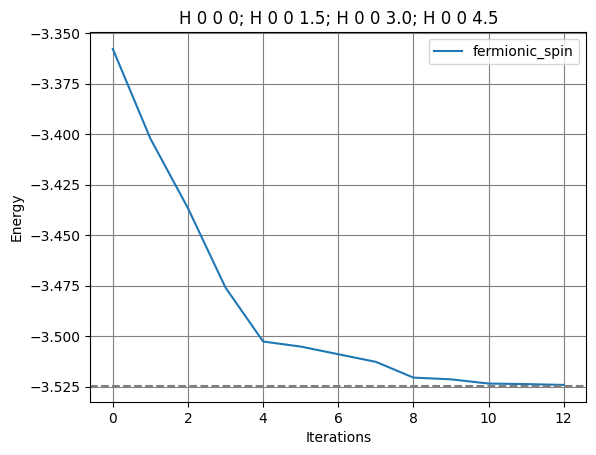

In [24]:
plt.plot(np.real(riemannian_flow.energies), label=operator_pool.operator_type)

plt.axhline(exact_energy, color="gray", linestyle="dashed")
plt.ylabel("Energy")
plt.xlabel("Iterations")
plt.title(mymol.atoms)
plt.grid(color="grey")
plt.legend()
plt.show()


Error to exact energy vs iterations in log plot

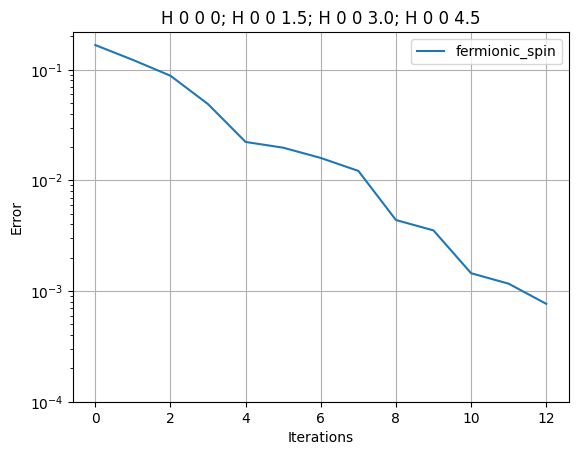

In [25]:
plt.plot(
    np.abs(riemannian_flow.energies - exact_energy), label=operator_pool.operator_type
)

plt.yscale("log")
plt.ylim(bottom=1e-4)
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.title(mymol.atoms)
plt.grid("grey")
plt.legend()
plt.show()


Error vs CNOT count

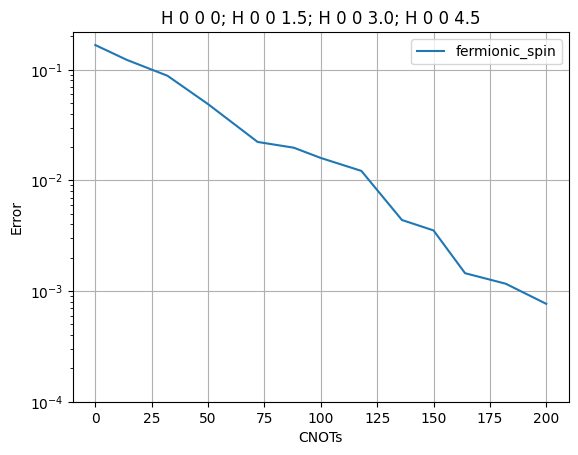

In [26]:
plt.plot(
    riemannian_flow.cnot_counts[0],
    np.abs(riemannian_flow.energies - exact_energy),
    label=operator_pool.operator_type,
)
plt.yscale("log")
plt.ylim(bottom=1e-4)
plt.ylabel("Error")
plt.xlabel("CNOTs")
plt.title(mymol.atoms)
plt.grid("grey")
plt.legend()
plt.show()


First penalty term (spin-2 error) vs iterations

/opt/conda/envs/aurora-py310/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/envs/aurora-py310/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


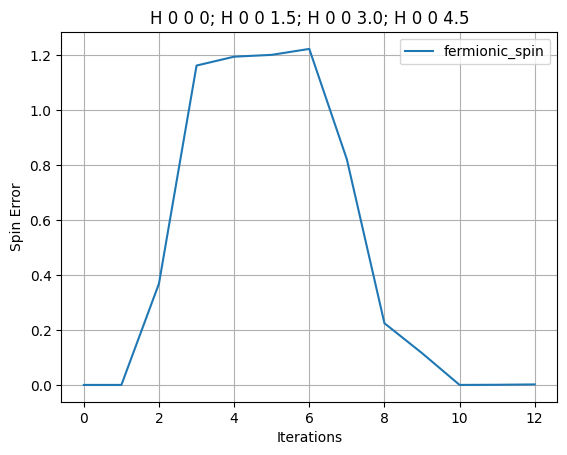

In [27]:
plt.plot(
    riemannian_flow.additional_operator_estimations[0],
    label=operator_pool.operator_type,
)
plt.ylabel("Spin Error")
plt.xlabel("Iterations")
plt.title(mymol.atoms)
plt.grid("grey")
plt.legend()
plt.show()


Second penalty term (number error) vs iterations

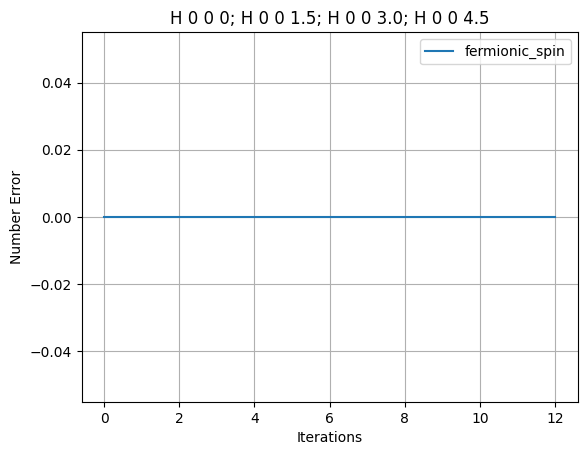

In [28]:
plt.plot(
    riemannian_flow.additional_operator_estimations[1],
    label=operator_pool.operator_type,
)
plt.ylabel("Number Error")
plt.xlabel("Iterations")
plt.title(mymol.atoms)
plt.grid("grey")
plt.legend()
plt.show()
